# Udacity project 1: Write a data science blog

This is the notebook of the analysis of a dataset for the udacity nanodegree program. The set chosen is that of AirBnb

In [322]:
# importing general libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr
# producing visualizations in notebook

%matplotlib inline
import visuals as vs
from time import time
# modelling libraries

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing  
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




# Introduction

The seattle data is analysed for the submission of the nanodegree with the aim of providing information that will guide stakeholders in making business decisions. The data is reviewed and abalysed with the aim of answering the following business questions.

1. What are the general availability trends? Is this a seasonal business or consistent throughout the year?
2. Does the availability have an impact on pricing? i.e. Is pricing also a seasonal trend.
3. What factors affect the pricing in general?
4. Why do those factors have a stronger weight in the pricing strategy.

These questions should provide insight to the stakeholders.

The data comes with three different sources. The calendar data for availability, the listing data and and the reviews data.

## Section 1: Data loading and review

In [323]:
# loading the data

cal_df = pd.read_csv('C:/Users/msema/Documents/Data science/Project one/calendar.csv')
df = pd.read_csv('C:/Users/msema/Documents/Data science/Project one/listings.csv')

## 1.1 Calendar data


A review of the calendar data

In [324]:
cal_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [325]:
cal_df['available'].nunique()

2

There are only two unique variable for availability. t and f

In [326]:
# Use a dictionary to convert the values to numerical

avail_dict = {'t': 1, 'f': 0}

In [327]:
cal_df['available'].replace(avail_dict, inplace = True)

In [328]:
cal_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,1,$85.00
1,241032,2016-01-05,1,$85.00
2,241032,2016-01-06,0,NaN
3,241032,2016-01-07,0,NaN
4,241032,2016-01-08,0,NaN


In [329]:
#Convert price data to a float

cal_df['price'] = cal_df.price.str.replace('$', '').str.replace(',', '').astype(float)

In [330]:
cal_df['date'] = pd.to_datetime(cal_df['date'], format="%Y-%m-%d")

In [331]:
## finding the total number of listings

cal_df['listing_id'].nunique()

3818

In [332]:
tot_listing = cal_df['listing_id'].nunique()

In [333]:
cal_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,NaN
3,241032,2016-01-07,0,NaN
4,241032,2016-01-08,0,NaN


In [334]:
cal_df.isna().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [335]:
cal_df.shape

(1393570, 4)

In [336]:
## There's missing data in the pricing. The question is the % of data missing?

miss_price = cal_df['price'].isna().sum()/cal_df.shape[0]*100

In [337]:
print(miss_price)

32.938998399793334


# 1.2 Listings data

In [338]:
# review of what the data looks like

df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [339]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [340]:
df.shape

(3818, 92)

In [341]:
#Checking columns with zero as a value data
no_nulls = set(df.columns[df.isnull().mean()==0])
print(no_nulls)

{'instant_bookable', 'description', 'street', 'minimum_nights', 'require_guest_profile_picture', 'guests_included', 'scrape_id', 'picture_url', 'jurisdiction_names', 'longitude', 'country', 'price', 'calendar_updated', 'listing_url', 'number_of_reviews', 'host_id', 'host_url', 'latitude', 'maximum_nights', 'requires_license', 'accommodates', 'bed_type', 'market', 'neighbourhood_cleansed', 'amenities', 'availability_365', 'require_guest_phone_verification', 'last_scraped', 'cancellation_policy', 'smart_location', 'id', 'experiences_offered', 'neighbourhood_group_cleansed', 'has_availability', 'name', 'availability_30', 'calendar_last_scraped', 'extra_people', 'calculated_host_listings_count', 'room_type', 'is_location_exact', 'city', 'host_verifications', 'country_code', 'availability_60', 'state', 'availability_90'}


In [342]:
#columns with most missing data
most_missing_cols = set(df.columns[df.isnull().mean() > 0.75])
print(most_missing_cols)

{'square_feet', 'license'}


In [343]:
#Check data types
df.dtypes.value_counts()

object     62
float64    17
int64      13
dtype: int64

In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

# Data Wrangling


## 1. Missing data review and removal

An analysis into the missing data in the process. This will be the first stage in removing features that will not be useful for the analysis.

In [345]:
#Form a missing data profile
missing = df.isna().sum()

In [346]:
missing.sort_values(ascending = False)

license             3818
square_feet         3721
monthly_price       2301
security_deposit    1952
weekly_price        1809
                    ... 
accommodates           0
bed_type               0
amenities              0
price                  0
id                     0
Length: 92, dtype: int64

Text(0.5, 0, 'Number of missing values')

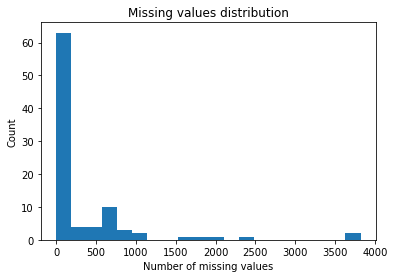

In [347]:
#Check the distribution of missing data
plt.hist(missing, bins = 20) 
plt.title("Missing values distribution")
plt.ylabel('Count')
plt.xlabel("Number of missing values")

In [348]:
# Remove the outlier columns from the dataset.
#Finding the P25 and 75 for the interquatile range
Q1, Q3 = np.percentile(missing, [25, 75]) 
print(Q1, Q3)

0.0 523.0


In [349]:
IQR = Q3 - Q1 #interquantile range
Upper = Q3 + 1.5*IQR # finding the upper limit
Lower = Q1 - 1.5*IQR # finding the lower limit

print('Upper limit is:', Upper)
print('Lower limit is:', Lower)

Upper limit is: 1307.5
Lower limit is: -784.5


In [350]:
Percentage_missing = (Upper/(df.shape[0]))*100
print('Minimum percentage of missing data:', int(Percentage_missing),'%')

Minimum percentage of missing data: 34 %


In [351]:
# Finding outlier columns

Outliers = missing[missing > Upper].index
print(Outliers)

Index(['notes', 'square_feet', 'weekly_price', 'monthly_price',
       'security_deposit', 'license'],
      dtype='object')


In [352]:
# removing outlier columns

df.drop(columns = Outliers, inplace = True)

In [353]:
df.shape

(3818, 86)

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 86 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  transit                           2884 non-null   object 
 11  thumbnail_url                     3498 non-null   object 
 12  medium

### Pattern recognition in missing data

Review if there is a pattern in the missing data

In [355]:

val = df.isna().sum()
per_miss_values = (val/df.shape[0])*100

Text(0.5, 0, 'Percentage')

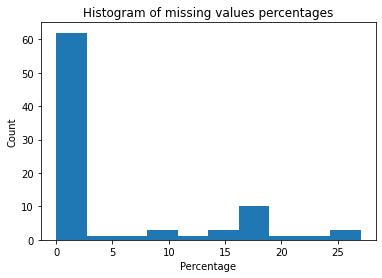

In [356]:
plt.hist(per_miss_values, bins = 10)
plt.title('Histogram of missing values percentages')
plt.ylabel('Count')
plt.xlabel('Percentage')

<AxesSubplot:>

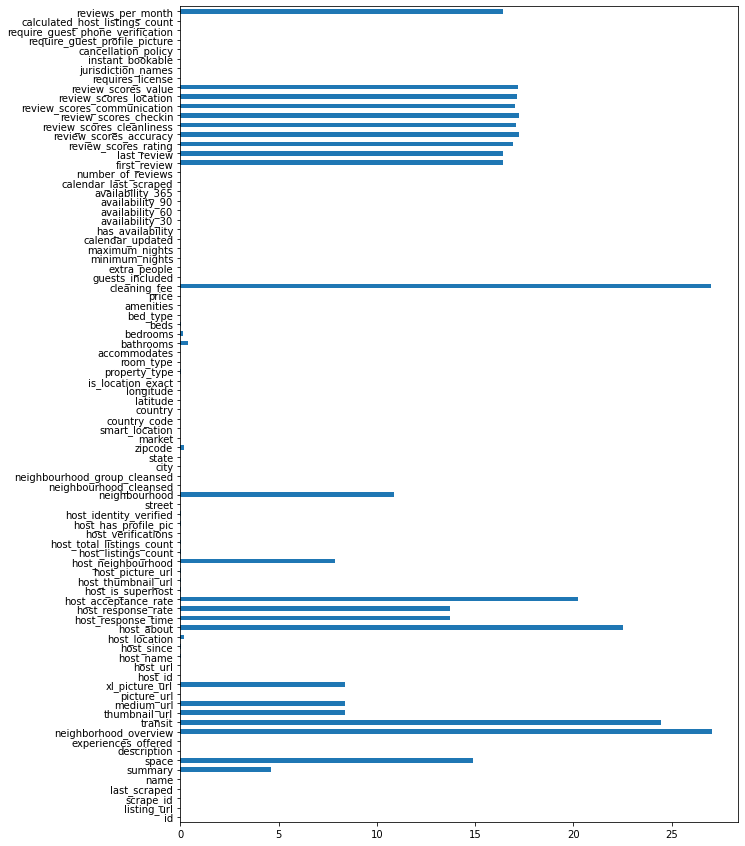

In [357]:
per_miss_values.plot.barh(figsize = (10, 15))

### Comment: 
The bar plot shows a few interest insights before hand.
1. The reviews are consistent in missing data. The initial assumption here is that this a result of people not conducting reviews. i.e. The scores are missing as a result of skipped reviews. Makes looking missing data by row relevant.
2. It seems listings prefer to withhold neighbourhood overviews

In [358]:
row_missing = df.isna().sum(axis = 1)

In [359]:
row_missing

0        7
1        0
2        3
3       21
4        4
        ..
3813     2
3814     0
3815    19
3816    14
3817    16
Length: 3818, dtype: int64

Text(0.5, 1.0, 'Missing values distribution per row')

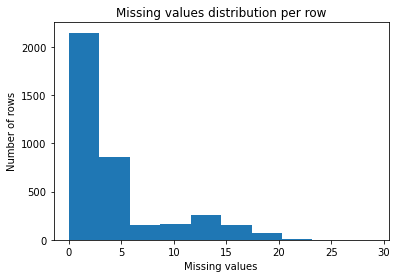

In [360]:
plt.hist(row_missing)
plt.xlabel('Missing values')
plt.ylabel('Number of rows')
plt.title('Missing values distribution per row')

## Feature encoding

### Dealing with categorical features

This is done as a feature encoding process to ensure the data used can be in modelling

In [361]:
# Identifying categorical features in the dataframe
#Reference: https://pbpython.com/categorical-encoding.html

obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,transit,thumbnail_url,...,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/241032,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,...,t,2016-01-04,2011-11-01,2016-01-02,f,WASHINGTON,f,moderate,f,f
1,https://www.airbnb.com/rooms/953595,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...","Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,...,t,2016-01-04,2013-08-19,2015-12-29,f,WASHINGTON,f,strict,t,t
2,https://www.airbnb.com/rooms/3308979,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,A bus stop is just 2 blocks away. Easy bus a...,NaN,...,t,2016-01-04,2014-07-30,2015-09-03,f,WASHINGTON,f,strict,f,f
3,https://www.airbnb.com/rooms/7421966,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,...,t,2016-01-04,NaN,NaN,f,WASHINGTON,f,flexible,f,f
4,https://www.airbnb.com/rooms/278830,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,The nearest public transit bus (D Line) is 2 b...,NaN,...,t,2016-01-04,2012-07-10,2015-10-24,f,WASHINGTON,f,strict,f,f


In [362]:
obj_df.columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'cleaning_fee', 'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'requires_license', 'j

### Comment: 

My judgement is that a few of these columns bring on additional value in terms of general analysis of the BnB itself:


These columns are listed below:
1. listing_url
2. thumbnail_url 
3. medium_url 
4. 'picture_url
5. xl_picture_url 
6. host_url
7. 'host_thumbnail_url'
8. 'host name'
9. 'host about'

These columns are dropped from the dataset

In [363]:
df.drop(columns = ['thumbnail_url', 'medium_url', 'picture_url', 
                   'xl_picture_url', 'host_url', 'host_name', 
                   'listing_url', 'host_about', 'host_thumbnail_url'], inplace = True)


In [364]:
df.shape

(3818, 77)

In [365]:
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   listing_url                       3818 non-null   object
 1   last_scraped                      3818 non-null   object
 2   name                              3818 non-null   object
 3   summary                           3641 non-null   object
 4   space                             3249 non-null   object
 5   description                       3818 non-null   object
 6   experiences_offered               3818 non-null   object
 7   neighborhood_overview             2786 non-null   object
 8   transit                           2884 non-null   object
 9   thumbnail_url                     3498 non-null   object
 10  medium_url                        3498 non-null   object
 11  picture_url                       3818 non-null   object
 12  xl_picture_url      

### Price and cleaning fee to be converted to numerical values


These are numerical values and should be analysed as such

In [366]:
df['price'] = df.price.str.replace('$', '').str.replace(',', '').astype(float)
df['cleaning_fee'] =  df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)

In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 77 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   scrape_id                         3818 non-null   int64  
 2   last_scraped                      3818 non-null   object 
 3   name                              3818 non-null   object 
 4   summary                           3641 non-null   object 
 5   space                             3249 non-null   object 
 6   description                       3818 non-null   object 
 7   experiences_offered               3818 non-null   object 
 8   neighborhood_overview             2786 non-null   object 
 9   transit                           2884 non-null   object 
 10  host_id                           3818 non-null   int64  
 11  host_since                        3816 non-null   object 
 12  host_l

In [368]:
obj_df.drop(columns = ['thumbnail_url', 'medium_url', 'picture_url', 
                   'xl_picture_url', 'host_url', 'host_name', 
                   'listing_url', 'host_about', 'host_thumbnail_url', 'price', 'cleaning_fee'], inplace = True)


In [369]:
cat_attributes = obj_df.columns

In [370]:
cat_attributes = list(cat_attributes)

In [371]:
### Perform a hotencoding to deal with the categorical data

final_df = pd.get_dummies(df, columns = cat_attributes)



In [372]:
final_df.head()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,jurisdiction_names_WASHINGTON,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,241032,20160104002432,956883,3.0,3.0,47.636289,-122.371025,4,1.0,1.0,...,1,1,0,0,1,0,1,0,1,0
1,953595,20160104002432,5177328,6.0,6.0,47.639123,-122.365666,4,1.0,1.0,...,1,1,0,0,0,1,0,1,0,1
2,3308979,20160104002432,16708587,2.0,2.0,47.629724,-122.369483,11,4.5,5.0,...,1,1,0,0,0,1,1,0,1,0
3,7421966,20160104002432,9851441,1.0,1.0,47.638473,-122.369279,3,1.0,0.0,...,1,1,0,1,0,0,1,0,1,0
4,278830,20160104002432,1452570,2.0,2.0,47.632918,-122.372471,6,2.0,3.0,...,1,1,0,0,0,1,1,0,1,0


In [373]:
# Remove missing data

final_df.dropna(inplace = True)

In [374]:
final_df.shape

(2390, 30142)

#### Finding numberical value

In [375]:

num_df = df.select_dtypes(include=['int64', 'float64']).copy()
num_df.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

# Section 2: Analysis and insight drawing


This is where the actual analysis occurs

# Data analysis motivation


The data generated can provide guidance to property owners in understanding the general trends and factors that would affect their operations if they list on Airbnb in the seattle area. Such factors will include the potential to generate revenue consistenty, and how to price in a competetive manner.  

1. What is the general availabiity of the listed properties?

2. What influences the listing price?

3. Can we use specific features to predict the review score?

## Part 2.1: General availability and seasonal impact

Is there a general trend in the listing availability? Is there a market for new airbnb's? And how does the price move due to seasonality?

Text(0.5, 0, 'date')

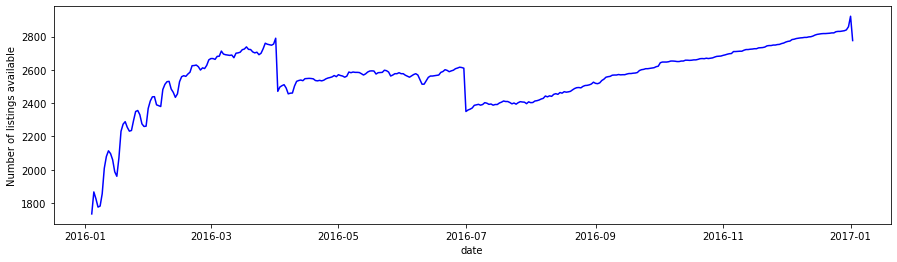

In [376]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
plt.rcParams.update({'font.size': 5})
cal_df.groupby(cal_df['date'].dt.date)['available'].sum().plot(color = 'b')
plt.ylabel('Number of listings available', size = 10)
plt.xlabel('date', size = 10)

In [377]:
avail_df = cal_df.groupby(cal_df['date'].dt.date)['available'].sum()

In [378]:
fraction = avail_df/tot_listing
fraction

date
2016-01-04    0.454426
2016-01-05    0.488999
2016-01-06    0.478261
2016-01-07    0.465165
2016-01-08    0.466737
                ...   
2016-12-29    0.742535
2016-12-30    0.743845
2016-12-31    0.748821
2017-01-01    0.765322
2017-01-02    0.727082
Name: available, Length: 365, dtype: float64

Text(0.5, 0, 'date')

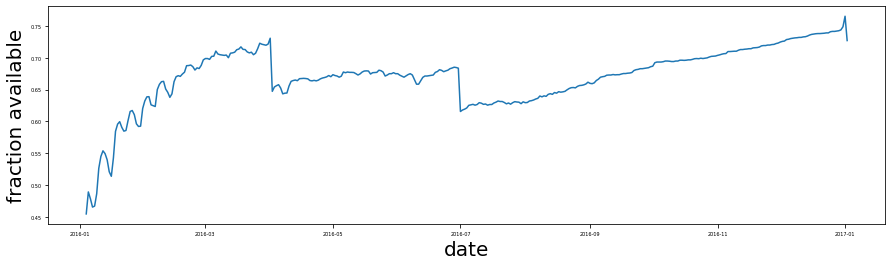

In [379]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
plt.rcParams.update({'font.size': 15})

fraction.plot()
plt.ylabel('fraction available', size = 20)
plt.xlabel('date', size = 20)

In [380]:
weekly_frac = cal_df.groupby(cal_df['date'].dt.weekday)['available'].sum() / tot_listing

Text(0.5, 0, 'date')

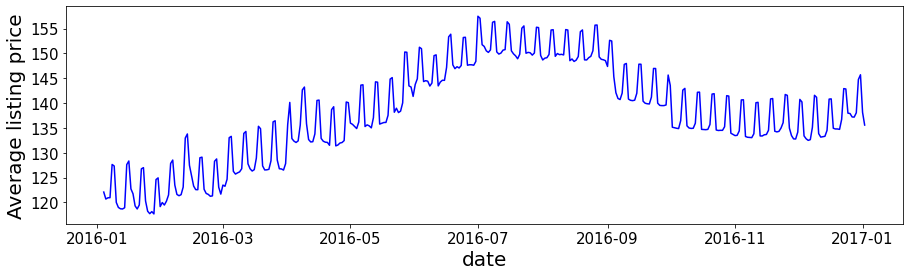

In [381]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
plt.rcParams.update({'font.size': 5})
cal_df.groupby(cal_df['date'].dt.date)['price'].mean().plot(color = 'b')
plt.ylabel('Average listing price', size = 20)
plt.xlabel('date', size = 20)

In [382]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
weekdays = cal_df.groupby(cal_df['date'].dt.weekday)['price'].mean()#.reindex(days)
weekdays

date
0    135.676414
1    135.408764
2    135.447880
3    136.476032
4    143.036294
5    143.202136
6    136.459941
Name: price, dtype: float64

In [383]:
weekdays = pd.DataFrame(weekdays)

In [384]:
weekdays.set_index(date)

NameError: name 'date' is not defined

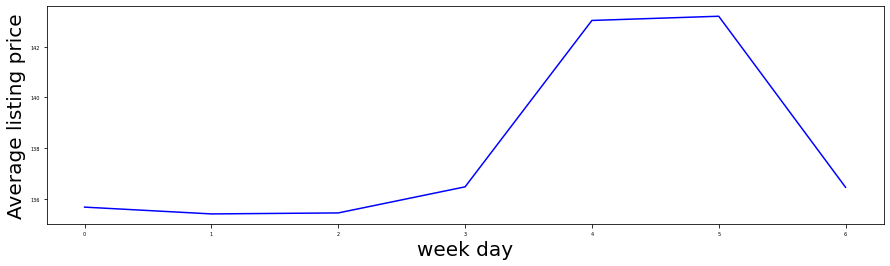

In [385]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

plt.rcParams.update({'font.size': 15})
cal_df.groupby(cal_df['date'].dt.weekday)['price'].mean().plot(color = 'b')
plt.ylabel('Average listing price', size = 20)
plt.xlabel('week day', size = 20)
plt.show()

Text(0.5, 0, 'Week day')

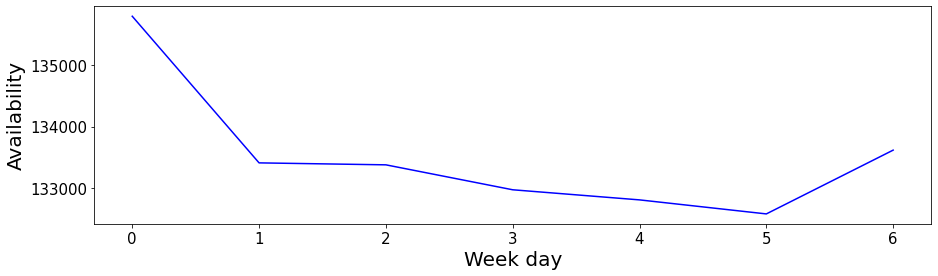

In [386]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
cal_df.groupby(cal_df['date'].dt.weekday)['available'].sum().plot(color = 'b')
plt.ylabel('Availability', size = 20)
plt.xlabel('Week day', size = 20)

In [387]:
cal_df.groupby(cal_df['date'].dt.weekday)['price'].mean()

date
0    135.676414
1    135.408764
2    135.447880
3    136.476032
4    143.036294
5    143.202136
6    136.459941
Name: price, dtype: float64

In [388]:
diff_est = (143-135)/135*100
diff_est

5.9259259259259265

### Comment: 
The weekend rate is higher than the weekday rates, with the spikes happenning on Friday.

The assumption for this analysis is that people generally check in on Friday for weekend vists and check-out on Sundays. Therefore, this explains the trend. 

Text(0.5, 0, 'Week day')

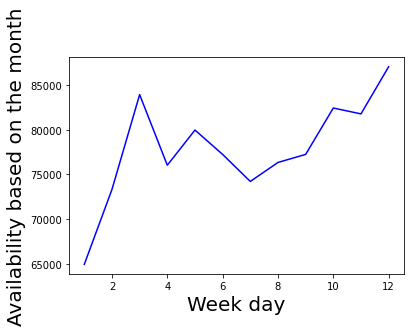

In [389]:
plt.rcParams.update({'font.size': 10})
cal_df.groupby(cal_df['date'].dt.month)['available'].sum().plot(color = 'b')
plt.ylabel('Availability based on the month', size = 20)
plt.xlabel('Week day', size = 20)

## Answer to the first question:


The availability in the data shows no seasonality trend that can be easily understood.

According to the data, there 3818 listings in total. However, there is no information about the number of rooms each can accomodate. Therefore, whether a listing is available or not, one cannot determine if this changed due to high bookings or not.

A diferrent review was then made on the day of week data. This would show the booking trends over the course of the week, with the following insights that can be drawn from the data:

1. The price increases by 6% on weekends as compared to the work days. 

This is a result of the availability change. With that said, this means an assumption can be drawn that most visits to seattle are not as a result of business dealings but rather leisure (assuming workdays are an indicator). With checkouts occuring on Sundays and Mondays having the highest availability

# Part 2.2: The price question


1. Which features have a direct relationship with the housing price?
2. Can price be predicted with with a certain level of accuracy? If so, what are the most important features in predicting the listing price?


<AxesSubplot:>

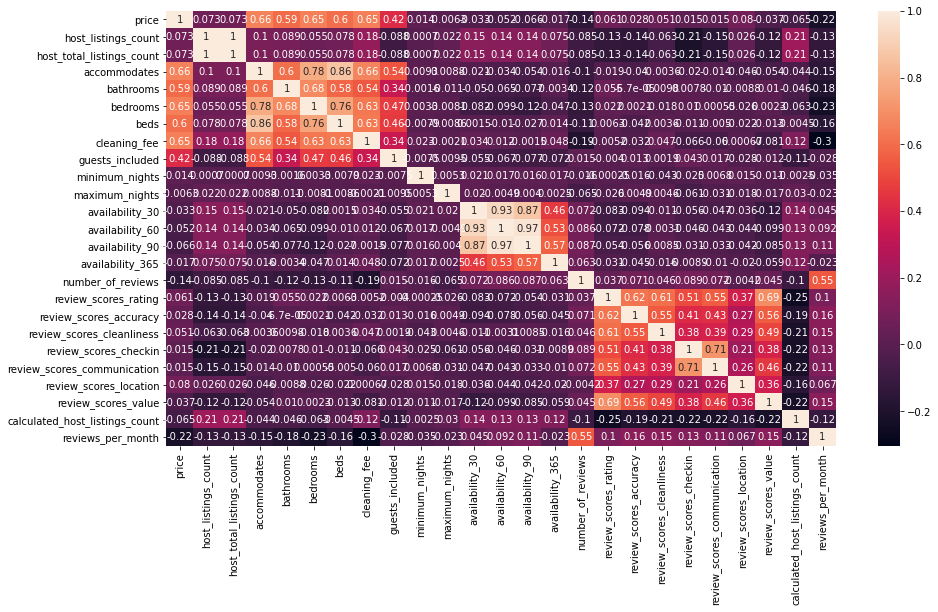

In [390]:
# The first is to plot a heat map to review any obvious correlations to the price from the numerical data


fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(data = final_df[['price', 'host_listings_count',
             'host_total_listings_count', 'accommodates',
             'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
             'guests_included', 'minimum_nights', 'maximum_nights',
             'availability_30', 'availability_60', 'availability_90',
             'availability_365', 'number_of_reviews', 'review_scores_rating',
             'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin', 'review_scores_communication',
             'review_scores_location', 'review_scores_value',
             'calculated_host_listings_count', 'reviews_per_month']].corr(), annot = True)

Text(0.5, 1.0, 'Price distribution')

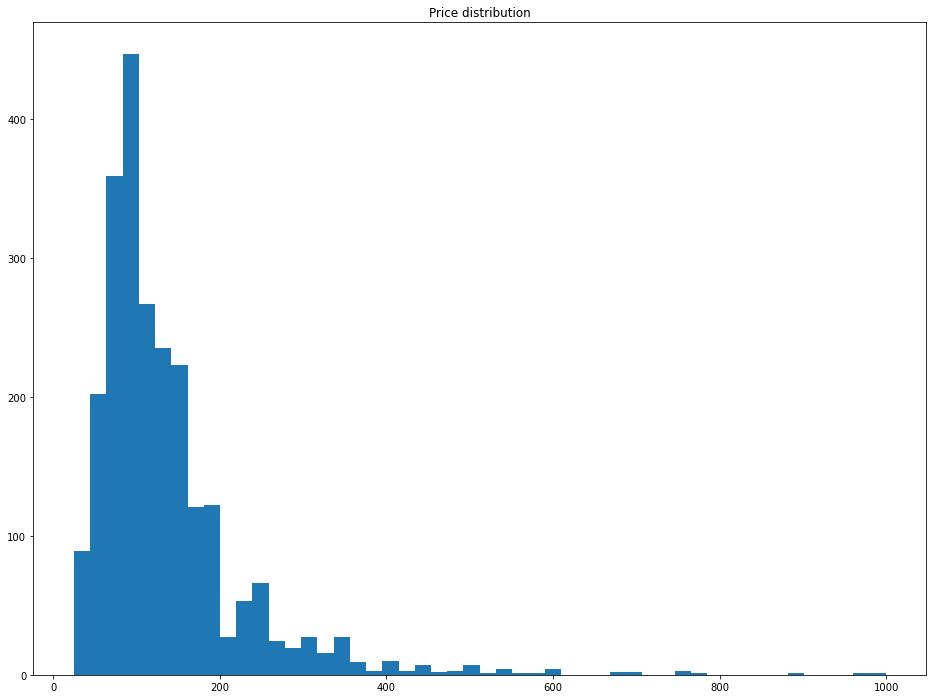

In [391]:
plt.figure(figsize = (16, 12))
#fig.set_figwidth(30)
plt.hist(final_df['price'], bins = 50)#, ax = ax1)
plt.title('Price distribution')

<AxesSubplot:>

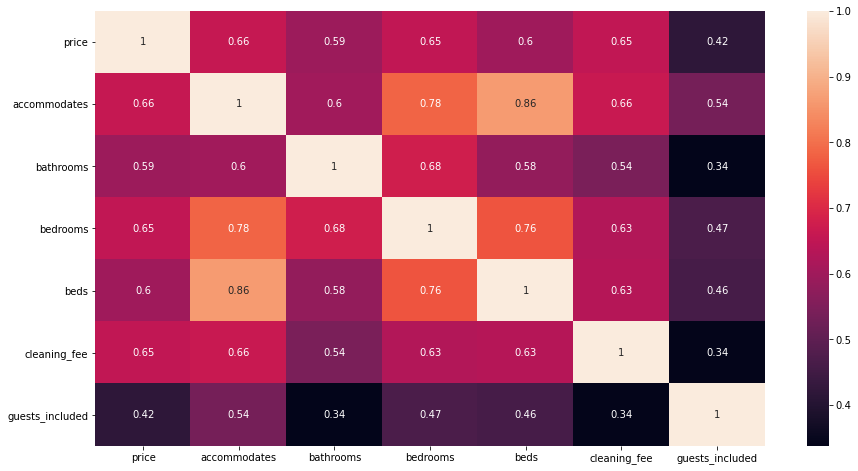

In [392]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(data = final_df[['price','accommodates',
             'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
             'guests_included']].corr(), annot = True)

### Answer to the first question


1. The number of people a place accomodates has a strong influence on the price at which it is listed on. This is intuitive and is shown in the data. 

A look at the correlations show that the number of people it can accomodate will increase with an increasing number of beds, and bedrooms as well as the number of bathrooms. Therefore giving an indication that the size of the place would generaly be larger, and thus influencing the price.

## Price prediction


In the above, the general correlation between features was detected. The next is a question of how accurately can we predict booking price based on the features in the data. And to what extent can the model be accurate. This section goes through a modelling exercise that takes these into consideration.

The model chosen for this particular exercise is the Random forest regressor.





In [393]:
# Setting the features for modelling the price
pricing_feat = final_df
#pricing_feat = final_df.drop(columns = 'price', inplace = True)



### Comment: Scaling the features to ensure normalized comparison of the features

1. Drop columns that will not count as a analysis factor for price. These will include the IDs.


In [394]:
pricing_feat

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,jurisdiction_names_WASHINGTON,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
1,953595,20160104002432,5177328,6.0,6.0,47.639123,-122.365666,4,1.0,1.0,...,1,1,0,0,0,1,0,1,0,1
2,3308979,20160104002432,16708587,2.0,2.0,47.629724,-122.369483,11,4.5,5.0,...,1,1,0,0,0,1,1,0,1,0
4,278830,20160104002432,1452570,2.0,2.0,47.632918,-122.372471,6,2.0,3.0,...,1,1,0,0,0,1,1,0,1,0
5,5956968,20160104002432,326758,1.0,1.0,47.630525,-122.366174,2,1.0,1.0,...,1,1,0,0,0,1,1,0,1,0
7,856550,20160104002432,4016632,5.0,5.0,47.640161,-122.375856,2,1.0,1.0,...,1,1,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,6120046,20160104002432,31752892,1.0,1.0,47.648689,-122.343915,4,1.0,1.0,...,1,1,0,0,0,1,1,0,1,0
3810,262764,20160104002432,1379138,1.0,1.0,47.654205,-122.352604,5,1.0,2.0,...,1,1,0,0,0,1,1,0,1,0
3811,8578490,20160104002432,11847918,1.0,1.0,47.657898,-122.346692,3,1.0,1.0,...,1,1,0,0,1,0,1,0,1,0
3813,8101950,20160104002432,31148752,354.0,354.0,47.664295,-122.359170,6,2.0,3.0,...,1,1,0,0,0,1,1,0,1,0


In [395]:
pricing_feat.drop(columns = ['id', 'scrape_id', 'latitude', 'longitude', 'host_id'], inplace = True)

In [396]:
#pricing_feat.drop()

In [397]:
'''# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = [ 'host_listings_count',
             'host_total_listings_count', 'accommodates',
             'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
             'guests_included', 'minimum_nights', 'maximum_nights',
             'availability_30', 'availability_60', 'availability_90',
             'availability_365', 'number_of_reviews', 'review_scores_rating',
             'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin', 'review_scores_communication',
             'review_scores_location', 'review_scores_value',
             'calculated_host_listings_count', 'reviews_per_month']

features_minmax_transform = pd.DataFrame(data = pricing_feat)
features_minmax_transform[numerical] = scaler.fit_transform(pricing_feat[numerical])

# Show an example of a record with scaling applied
display(features_minmax_transform.head(n = 5))'''

"# Import sklearn.preprocessing.StandardScaler\nfrom sklearn.preprocessing import MinMaxScaler\n\n# Initialize a scaler, then apply it to the features\nscaler = MinMaxScaler() # default=(0, 1)\nnumerical = [ 'host_listings_count',\n             'host_total_listings_count', 'accommodates',\n             'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',\n             'guests_included', 'minimum_nights', 'maximum_nights',\n             'availability_30', 'availability_60', 'availability_90',\n             'availability_365', 'number_of_reviews', 'review_scores_rating',\n             'review_scores_accuracy', 'review_scores_cleanliness',\n             'review_scores_checkin', 'review_scores_communication',\n             'review_scores_location', 'review_scores_value',\n             'calculated_host_listings_count', 'reviews_per_month']\n\nfeatures_minmax_transform = pd.DataFrame(data = pricing_feat)\nfeatures_minmax_transform[numerical] = scaler.fit_transform(pricing_feat[numerical])\n\n# S

In [398]:
final_df.columns

Index(['host_listings_count', 'host_total_listings_count', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee',
       'guests_included', 'minimum_nights',
       ...
       'jurisdiction_names_WASHINGTON', 'instant_bookable_f',
       'instant_bookable_t', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'require_guest_profile_picture_f', 'require_guest_profile_picture_t',
       'require_guest_phone_verification_f',
       'require_guest_phone_verification_t'],
      dtype='object', length=30137)

In [399]:
y = final_df['price']

In [400]:
pricing_feat.drop(columns = 'price', inplace = True)

In [401]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pricing_feat, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [402]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1912 samples.
Testing set has 478 samples.


In [403]:
model = RandomForestRegressor(random_state = 0)

In [404]:
#ore_model = LinearRegression(normalize = True)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

### Model evaluation:


This section evaluates the model performance. A few iterations were conducted before a final model parameter was chasing.



In [405]:
test_preds = model.predict(X_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, test_preds), len(y_test))

'The r-squared score for your model was 0.6965877481676883 on 478 values.'

In [406]:
model.score(X_test, y_test)

0.6965877481676883

In [407]:
parity = pd.DataFrame({'Actual': y_test, 'Predicted': test_preds})

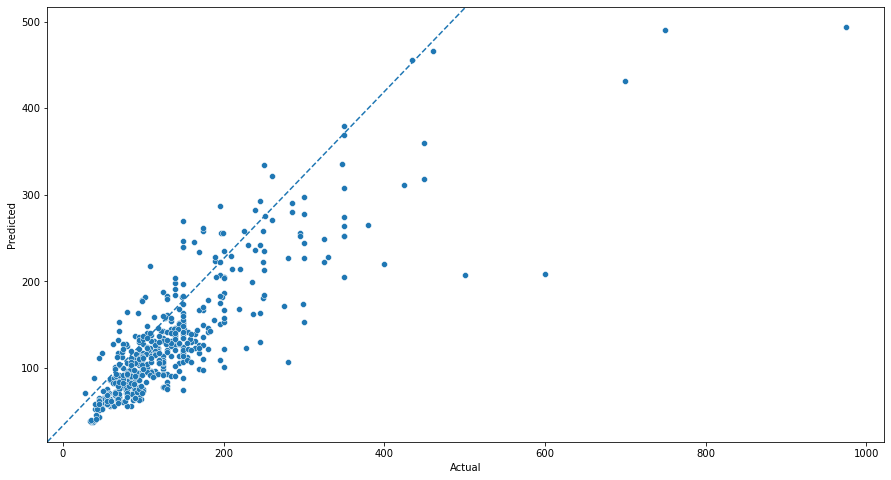

In [408]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(x = parity['Actual'], y = parity['Predicted'] )
ax.plot([0,1],[0,2], transform=ax.transAxes, ls = '--')




In [409]:
## Reference: Code and approach were used in previous nanodegree: 'Introduction to machine learning' 

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (10,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

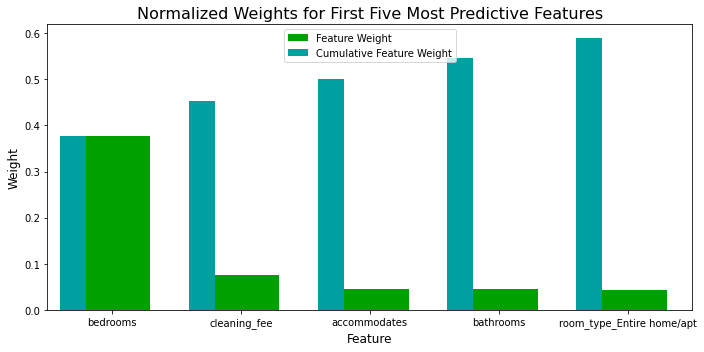

In [410]:
importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

### Answer to question:

The price can be predicted with a R^2 of 0.69, which I deem acceptable.

The most important features for the AirBnB listing prices are the following;
1. Number of bedrooms
2. The cleaning fee.
3. The number of bathrooms
4. The number of people it can accomodate
5. The type of property that is to be listed.


The above makes send because the provide a view of how big the property it is, as well as the level of comfort a guest can expect at such a place. 